In [1]:
import logging
from meri.bot import get_user_agent
import requests
import requests_cache
import tempfile

import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from pytz import timezone, utc

from tqdm.notebook import trange
import ipywidgets as widgets

requests_cache.install_cache(f"{tempfile.gettempdir()}/klikkikuri_requests_cache")
logger = logging.getLogger('meri')
logger.setLevel(logging.DEBUG)

In [2]:


def collect_news_publish_times(n=2000):
    """
    Collect article publish times from Iltalehti.
    """
    from tqdm import trange
    from meri.bot import get_user_agent

    url = r"https://api.il.fi/v1/articles/iltalehti/lists/latest?limit={batch_size}&date_end={previous_datetime}&include_palat=true&image_sizes[]=size138"

    batch_size = 30
    article_times = []
    # Create a EEST datetime object, which is the timezone used by Iltalehti
    previous_datetime = datetime.now(timezone("Europe/Helsinki"))

    # For caching purposes, set the time to 00:00:00
    previous_datetime = previous_datetime.replace(hour=0, minute=0, second=0, microsecond=0)

    session = requests.Session()
    session.headers.update({
        "User-Agent": get_user_agent()
    })
    for i in trange(0, n, batch_size, unit="batch"):
        f_url = url.format(batch_size=batch_size, previous_datetime=previous_datetime.isoformat())
        logger.debug("Fetching batch %d from %s", i, f_url)
        res = session.get(f_url, timeout=10)
        res.raise_for_status()
        data = res.json()
        for article in data["response"]:
            # Ignore updated article, as update articles are messes up the prediction and it's easier to just ignore
            # them.
            if article.get("updated_at"):
                logger.debug("Skipping updated article: %r", article["title"])
                continue

            published_at = article["published_at"]
            previous_datetime = datetime.fromisoformat(published_at)
            # Check that the article has timezone
            if previous_datetime.tzinfo is None:
                raise ValueError(f"Article has no timezone information: {article['published_at']}")

            # Sanity check: Check that this article is older than the previous one
            if article_times and previous_datetime > article_times[-1]:
                raise ValueError(f"Article is newer than the previous one: {previous_datetime} > {article_times[-1]}")
            article_times.append(previous_datetime)

    # Convert to UTC
    article_times = [time.astimezone(utc) for time in article_times]

    return article_times

number_of_articles = widgets.IntText(
    value=2000,
    description='Number of articles to fetch:',
    disabled=False
)
display(number_of_articles)

IntText(value=2000, description='Number of articles to fetch:')

In [3]:
print("Fetching article publish times from Iltalehti")
article_times = collect_news_publish_times(int(number_of_articles.value))
print("Fetched", len(article_times), "article publish times from Iltalehti")
logger.info("Collected %d publish times from %s to %s", len(article_times), article_times[0], article_times[-1])


Fetching article publish times from Iltalehti


100%|██████████| 67/67 [00:00<00:00, 239.70batch/s]

Fetched 1807 article publish times from Iltalehti


In [4]:
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


def prepare_data(published_at: list[datetime]):
    # Convert datetime into DataFrame and sort it
    df = pd.DataFrame(published_at, columns=["published_at"], dtype='datetime64[ns, UTC]')
    df = df.sort_values('published_at')

    # Calculate time differences in minutes
    df['time_diff'] = df['published_at'].diff().dt.total_seconds() / 60
    df.dropna(subset=['time_diff'], inplace=True)  # Remove first row (NaN)

    # Convert published_at to minutes since midnight
    df['minutes_since_midnight'] = df['published_at'].dt.hour * 60 + df['published_at'].dt.minute

    return df


def fit_polynomial_model(df: pd.DataFrame, degree: int = 3):
    # Extract features and target variable
    X = df['minutes_since_midnight'].values.reshape(-1, 1)
    #X = df[['sin_time', 'cos_time']]
    y = df['time_diff']

    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly_features.fit_transform(X)

    # Fit the polynomial regression model
    model = LinearRegression()
    model.fit(X_poly, y)

    # Extract coefficients and intercept
    coefficients = model.coef_
    intercept = model.intercept_

    return coefficients, intercept


def polynomial_delay_estimation(minutes_since_midnight: float, coefficients: np.ndarray, intercept: float):
    # Calculate the polynomial value
    estimated_delay = intercept
    power = 1  # Start from x^1
    for coeff in coefficients:
        estimated_delay += coeff * (minutes_since_midnight ** power)
        power += 1  # Increment the power

    return estimated_delay


def predict_delay_using_polynomial(current_time: datetime, coefficients: np.ndarray, intercept: float):
    # Convert current time to minutes since midnight
    current_time_in_minutes = current_time.hour * 60 + current_time.minute

    # Use the polynomial function to estimate delay
    predicted_delay = polynomial_delay_estimation(current_time_in_minutes, coefficients, intercept)

    return predicted_delay


# Prepare the data
df = prepare_data(article_times)

# Fit the polynomial model and get coefficients
coefficients, intercept = fit_polynomial_model(df, degree=5)

# Predict the delay for a specific time
current_time = datetime.now(utc)  # Example time to predict
predicted_delay = predict_delay_using_polynomial(current_time, coefficients, intercept)

print(f"Predicted average delay: {predicted_delay:.2f} minutes")

print(str(coefficients.tolist()))
print(intercept)


Predicted average delay: 10.18 minutes
[-0.7748053902642059, 0.0020853780675782244, -2.455949822787182e-06, 1.2410447589884303e-09, -1.9835131800927108e-13]
109.00180688246368


Mean Absolute Error: 8.28 minutes
Mean Squared Error: 185.47 minutes squared


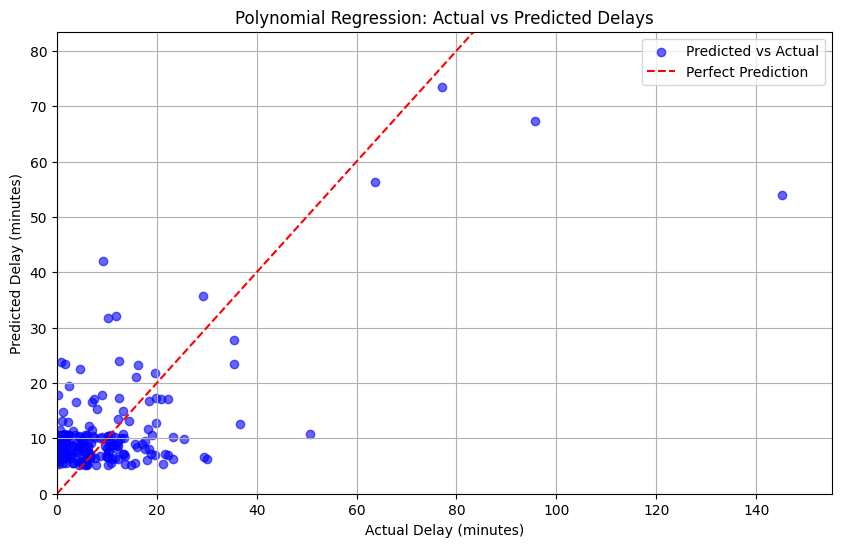

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def evaluate_performance(df: pd.DataFrame, coefficients: np.ndarray, intercept: float):
    # Predict delays for all publishing times in the dataframe
    predicted_delays = []
    # Select a sample of the data for evaluation
    sample = df.sample(n=200, random_state=1)

    for _, row in sample.iterrows():
        predicted_delay = predict_delay_using_polynomial(row['published_at'], coefficients, intercept)
        predicted_delays.append(predicted_delay)

    # Extract actual delays
    actual_delays = sample['time_diff'].values
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(actual_delays, predicted_delays, color='blue', label='Predicted vs Actual', alpha=0.6)
    
    # Reference line for perfect predictions
    plt.plot([0, max(actual_delays)], [0, max(actual_delays)], color='red', linestyle='--', label='Perfect Prediction')
    
    # Labels and title
    plt.xlabel('Actual Delay (minutes)')
    plt.ylabel('Predicted Delay (minutes)')
    plt.title('Polynomial Regression: Actual vs Predicted Delays')
    plt.legend()
    plt.grid()
    plt.xlim(0, max(actual_delays) + 10)  # Add some margin
    plt.ylim(0, max(predicted_delays) + 10)  # Add some margin
    plt.show()


def evaluate_model(df: pd.DataFrame, coefficients: np.ndarray, intercept: float):
    # Predict delays using the polynomial model for evaluation
    predicted_delays = df['minutes_since_midnight'].apply(lambda t: polynomial_delay_estimation(t, coefficients, intercept))

    # Calculate metrics
    mae = mean_absolute_error(df['time_diff'], predicted_delays)
    mse = mean_squared_error(df['time_diff'], predicted_delays)

    print(f'Mean Absolute Error: {mae:.2f} minutes')
    print(f'Mean Squared Error: {mse:.2f} minutes squared')


# Evaluate model performance
evaluate_model(df, coefficients, intercept)

evaluate_performance(df, coefficients, intercept)